<a href="https://colab.research.google.com/github/apurvaapatil/Amazon-Sentiment-Analysis/blob/main/Amazon_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
import re
import nltk
from nltk import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Reading and performing basic analysis of the data

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d datafiniti/consumer-reviews-of-amazon-products

consumer-reviews-of-amazon-products.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip consumer-reviews-of-amazon-products.zip

Archive:  consumer-reviews-of-amazon-products.zip
replace 1429_1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
amazon_reviews = pd.read_csv('1429_1.csv')
amazon_reviews.head(5)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [ ]:
amazon_reviews=amazon_reviews[['reviews.rating', 'reviews.text']]
amazon_reviews=amazon_reviews
amazon_reviews.head()

,reviews.rating,reviews.text
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [ ]:
100 * amazon_reviews['reviews.rating'].value_counts()/len(amazon_reviews)

5.0    68.594922
4.0    24.642239
3.0     4.324870
1.0     1.182920
2.0     1.159838
Name: reviews.rating, dtype: float64

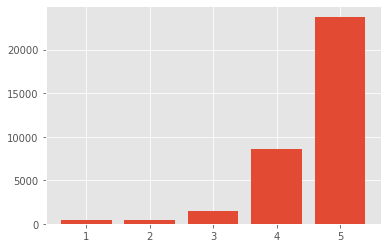

In [ ]:
count = amazon_reviews['reviews.rating'].value_counts()
plt.bar(count.index, count.values)
plt.show()

In [ ]:
data2 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
data2 = data2[['reviews.rating' , 'reviews.text']]
data2 = data2[data2["reviews.rating"]<=3]

data3 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
data3 = data3[['reviews.rating' , 'reviews.text']]
data3 = data3[data3["reviews.rating"]<=3]

frames = [amazon_reviews, data2, data3]
amazon_reviews = pd.concat(frames)
amazon_reviews = amazon_reviews.dropna()

del data2,data3, frames

In [ ]:
100 * amazon_reviews['reviews.rating'].value_counts()/len(amazon_reviews)

5.0    63.015877
4.0    22.638959
3.0     7.692104
1.0     3.811594
2.0     2.841466
Name: reviews.rating, dtype: float64

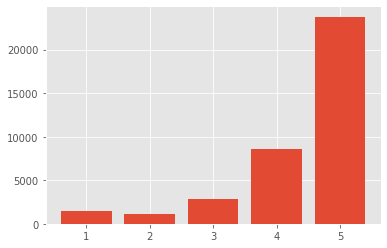

In [ ]:
count = amazon_reviews['reviews.rating'].value_counts()
plt.bar(count.index, count.values)
plt.show()

#Converting the ratings for sentiment analysis

For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the follow rule:

*   Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews
*   Ratings of 3 will get mapped to 1 as neutral reviews.
*   Ratings of 4 or 5 will get mapped to 2 and will be reltead to positive reviews


In [ ]:
sentiment = {1:0, 2:0, 3:1, 4:2, 5:2}
amazon_reviews['sentiment_rating'] = amazon_reviews['reviews.rating'].map(sentiment)

# # Printing the counts of each rating
amazon_reviews['sentiment_rating'].value_counts()
del sentiment

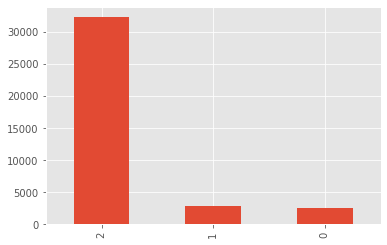

In [ ]:
amazon_reviews['sentiment_rating'].value_counts().plot.bar()

#Word Cloud

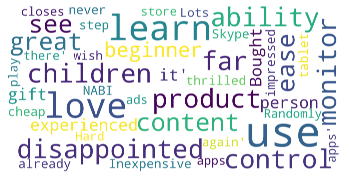

In [ ]:
text = amazon_reviews['reviews.text'].values 

wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", scale = 10, width=800, height=400).generate(str(text))

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#Pre-processing

Converting words to lower/upper case

In [ ]:
amazon_reviews['reviews_text_new'] = amazon_reviews['reviews.text'].str.lower()

Removing special characters from the reviews by applying a regular expression:

In [ ]:
amazon_reviews['reviews_text_new'] = amazon_reviews['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', '')

In [ ]:
print("- Old Review -")
print(amazon_reviews['reviews.text'][3])
print("\n- New Review -")
print(amazon_reviews['reviews_text_new'][3])

- Old Review -
I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Prime content as well as movies you can download and watch laterThis has a 1280/800 screen which has some really nice look to it its nice and crisp and very bright infact it is brighter then the ipad pro costing $900 base model. The build on this fire is INSANELY AWESOME running at only 7.7mm thick and the smooth glossy feel on the back it is really amazing to hold its like the futuristic tab in ur hands.

- New Review -
ive had my fire hd 8 two weeks now and i love it this tablet is a great valuewe are prime members and that is where this tablet shines i love being able to easily access all of the prime content as well as movies you can download and watch laterthis has a 1280800 screen which has some really nice look to it its nice and crisp and very bright infact it is brighter then the 

3. Removing StopWords


In [ ]:
stop_words = stopwords.words('english')
stop_words.remove("not")

words_descriptions = amazon_reviews['reviews_text_new'].str.split()
words_descriptions = words_descriptions.apply(lambda elem: [word for word in elem if not word in stop_words])

ps = PorterStemmer()

words_descriptions = words_descriptions.apply(lambda elem: [ps.stem(word) for word in elem])

In [ ]:
amazon_reviews['cleaned'] = words_descriptions.apply(lambda elem: ' '.join(elem))
amazon_reviews['cleaned'].sample(5)

27740      companion talk music news current event lot fun
8424     got amazon fire tabl love realli easi use batt...
33626    work suppos look good besid black tv realli go...
5997     purchas test cost less 50 work awesom faster e...
23847    love echo use mani thing bought batteri goe ev...
Name: cleaned, dtype: object

#Building a machine learning model

TF-IDF model

TF-IDF stands for “Term Frequency — Inverse Data Frequency”. It gives us the frequency of the word in each document in the corpus.

> **Term Frequency (tf):** is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases.


> **Inverse Data Frequency (idf)**: used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score.





In [ ]:
nltk.download('punkt')

vectorizer = CountVectorizer()
data_features = vectorizer.fit_transform(amazon_reviews['cleaned'])

tfidf_transformer = TfidfTransformer()
vectorized_text = tfidf_transformer.fit_transform(data_features).toarray()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
vectorized_text.shape

(37727, 14821)

Training and Test sets:

In [ ]:
y = amazon_reviews['sentiment_rating'].values
X = pd.DataFrame(vectorized_text)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Applying logistic regression

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

lr = LogisticRegression()
lr.fit(X_train, y_train)

## Predicting the output
print('Train Accuracy: ', lr.score(X_train, y_train) * 100)
print('Test Accuracy: ', lr.score(X_test, y_test) * 100)

      
print('\n CONFUSION MATRIX')
print(confusion_matrix(y_test, lr.predict(X_test)))
print('\nCLASSIFICATION REPORT')
print(classification_report(y_test, lr.predict(X_test)))

Train Accuracy:  92.40581823001226
Test Accuracy:  90.68380598992843

 CONFUSION MATRIX
[[ 316   40  161]
 [  59  177  353]
 [  22   68 6350]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.80      0.61      0.69       517
           1       0.62      0.30      0.41       589
           2       0.93      0.99      0.95      6440

    accuracy                           0.91      7546
   macro avg       0.78      0.63      0.68      7546
weighted avg       0.89      0.91      0.89      7546



Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

print('Train accuracy :', (nb.score(X_train, y_train))*100)
print('Test accuracy :', (nb.score(X_test, y_test))*100)
      
print('\n CONFUSION MATRIX')
print(confusion_matrix(y_test, nb.predict(X_test)))
print('\nCLASSIFICATION REPORT')
print(classification_report(y_test, nb.predict(X_test)))

Train accuracy : 87.05145621417448
Test accuracy : 86.60217333686721

 CONFUSION MATRIX
[[  94    3  420]
 [  18    4  567]
 [   0    3 6437]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.18      0.30       517
           1       0.40      0.01      0.01       589
           2       0.87      1.00      0.93      6440

    accuracy                           0.87      7546
   macro avg       0.70      0.40      0.41      7546
weighted avg       0.83      0.87      0.81      7546



Testing the models using examples

In [ ]:
review1 = "This is what i am looking for"
review2 = "The package was ok"
review3 = "This kindle is the worst"

print("Using Logistic regression\n")
print(review1, ":", lr.predict(vectorizer.transform([review1])))
print(review2, ":",lr.predict(vectorizer.transform([review2])))
print(review3, ":",lr.predict(vectorizer.transform([review3])))

print("\nUsing Multinomial Naive Bayes\n")
print(review1, ":", nb.predict(vectorizer.transform([review1])))
print(review2, ":",nb.predict(vectorizer.transform([review2])))
print(review3, ":",nb.predict(vectorizer.transform([review3])))

Using Logistic regression

This is what i am looking for : [2]
The package was ok : [1]
This kindle is the worst : [0]

Using Multinomial Naive Bayes

This is what i am looking for : [2]
The package was ok : [2]
This kindle is the worst : [0]
